In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [2]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

## Helper Methods

In [3]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
    """Lists videos available in UCF101 dataset."""
    global _VIDEO_LIST
    if not _VIDEO_LIST:
        index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
        videos = re.findall("(v_[\w_]+\.avi)", index)
        _VIDEO_LIST = sorted(set(videos))
    return list(_VIDEO_LIST)

def fetch_ucf_video(video):
    """Fetches a video and cache into local filesystem."""
    cache_path = os.path.join(_CACHE_DIR, video)
    if not os.path.exists(cache_path):
        urlpath = request.urljoin(UCF_ROOT, video)
        print("Fetching %s => %s" % (urlpath, cache_path))
        with request.urlopen(urlpath, context=unverified_context) as response, open(cache_path, "wb") as f:
            while True:
                chunk = response.read(8192)
                if not chunk:
                    break
                f.write(chunk)
    return cache_path


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=40)
    return embed.embed_file('./animation.gif')

def extract_frames_from_video(video_path, max_frames=None, resize=None):
    """
    Extract frames from a video file.

    Args:
    - video_path (str): Path to the video file.
    - max_frames (int, optional): Maximum number of frames to extract. If None, extract all frames.
    - resize (tuple, optional): Desired size to resize the frames, e.g., (width, height).

    Returns:
    - frames (list of numpy arrays): List containing extracted frames.
    """

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Unable to open video file:", video_path)

    frames = []
    frame_count = 0

    try:
        while True:
            # Read a frame from the video
            ret, frame = cap.read()
            if not ret:
                break  # No more frames to read

            # Optionally resize the frame
            if resize is not None:
                frame = cv2.resize(frame, resize)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append the frame to the list
            frames.append(frame)

            frame_count += 1
            if max_frames is not None and frame_count >= max_frames:
                break  # Reached maximum number of frames

    finally:
        # Release the video capture object
        cap.release()

    return frames

## Frames Extraction and DataFrame Preparation

In [4]:
import pandas as pd
batch_size = 5

ucf_videos = list_ucf_videos()
ucf_videos = list_ucf_videos()[:300]
video_paths = []
labels = []
frames = []
count = 0

for i in range(0, len(ucf_videos), batch_size):
    # Select a batch of videos
    batch_videos = ucf_videos[i:i+batch_size]

    # Initialize lists to store batch-specific data
    batch_video_paths = []
    batch_labels = []
    batch_frames = []

    # Loop through videos in the batch
    for video in batch_videos:
        # Fetch the video and cache it locally
        video_path = fetch_ucf_video(video)
        print(count)
        count = count + 1
        # Extract frames from the video using the load_video function
        video_frames = extract_frames_from_video(video_path,max_frames=50,resize=(224, 224))
        # Extract label from the video filename
        label = video.split('_')[1]
        # Append video path, label, and frames to the batch-specific lists
        batch_video_paths.append(video_path)
        batch_labels.append(label)
        batch_frames.append(video_frames)

    # Append batch-specific data to the main lists
    video_paths.extend(batch_video_paths)
    labels.extend(batch_labels)
    frames.extend(batch_frames)

# Create a DataFrame to store the data
df = pd.DataFrame({
    'video_path': video_paths,
    'label': labels,
    'frames': frames
})

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c01.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c01.avi
0
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c02.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c02.avi
1
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c03.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c03.avi
2
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c04.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c04.avi
3
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c05.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c05.avi
4
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g01_c06.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g01_c06.avi
5
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_ApplyEyeMakeup_g02_c01.avi => /tmp/tmpbp6a3h8d/v_ApplyEyeMakeup_g02_c01.avi
6
Fetching https://www.crcv.ucf.edu/THUMOS1

## Apply Label Encoding

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(df['label'])

# Update the DataFrame with the encoded labels
df['label'] = encoded_labels


## Spliting Data into Test and Train

In [6]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


## Defining the Methods We will use to Extract Features

In [7]:
import tensorflow as tf

# Define the feature extractor
def create_feature_extractor(input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    feature_extractor = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    return feature_extractor

# Initialize the feature extractor
feature_extractor = create_feature_extractor()

# Function to extract features from frames of a single video
def extract_features_from_video(frames):
    frame_features = []
    for frame in frames:
        frame = tf.image.resize(frame, (224, 224))
        frame = tf.keras.applications.inception_v3.preprocess_input(frame)
        features = feature_extractor(tf.expand_dims(frame, axis=0))
        frame_features.append(features)
    return frame_features



87910968/87910968 [==============================] - 1s 0us/step


## Extracting the Features "CNN"

In [8]:
# Extract features from train_data
train_data_features = []
for video_frames in train_data['frames']:
    video_features = extract_features_from_video(video_frames)
    train_data_features.append(video_features)

# Extract features from validation_data
validation_data_features = []
for video_frames in validation_data['frames']:
    video_features = extract_features_from_video(video_frames)
    validation_data_features.append(video_features)

test_data_features = []
for video_frames in test_data['frames']:
    video_features = extract_features_from_video(video_frames)
    test_data_features.append(video_features)


# Convert the features to TensorFlow tensors
train_data_features = tf.convert_to_tensor(train_data_features)
validation_data_features = tf.convert_to_tensor(validation_data_features)
test_data_features = tf.convert_to_tensor(test_data_features)
test_data_labels = tf.convert_to_tensor(test_data['label'])
train_data_labels = tf.convert_to_tensor(train_data['label'])
validation_data_labels = tf.convert_to_tensor(validation_data['label'])


## Reshaping Features to pass it to the RNN

In [9]:
# Reshape the features
train_data_features = tf.reshape(train_data_features, (-1, 50, 2048))
validation_data_features = tf.reshape(validation_data_features, (-1, 50, 2048))
test_data_features = tf.reshape(test_data_features, (-1, 50, 2048))

## Appling RNN Model

In [10]:
# Create an RNN model
rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, return_sequences=True),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the model
rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
rnn_model.fit(train_data_features, train_data_labels,
              validation_data=(validation_data_features,validation_data_labels),
              epochs=10)

Epoch 1/10
8/8 [==============================] - 8s 354ms/step - loss: 1.6419 - accuracy: 0.4250 - val_loss: 1.0515 - val_accuracy: 0.7000
Epoch 2/10
8/8 [==============================] - 2s 210ms/step - loss: 0.8246 - accuracy: 0.7417 - val_loss: 0.5420 - val_accuracy: 0.8667
Epoch 3/10
8/8 [==============================] - 2s 253ms/step - loss: 0.4062 - accuracy: 0.9125 - val_loss: 0.2264 - val_accuracy: 0.9667
Epoch 4/10
8/8 [==============================] - 2s 295ms/step - loss: 0.2267 - accuracy: 0.9458 - val_loss: 0.1145 - val_accuracy: 0.9667
Epoch 5/10
8/8 [==============================] - 2s 197ms/step - loss: 0.1262 - accuracy: 0.9667 - val_loss: 0.3796 - val_accuracy: 0.9000
Epoch 6/10
8/8 [==============================] - 1s 185ms/step - loss: 0.1649 - accuracy: 0.9583 - val_loss: 0.1113 - val_accuracy: 0.9333
Epoch 7/10
8/8 [==============================] - 1s 188ms/step - loss: 0.0627 - accuracy: 0.9958 - val_loss: 0.0897 - val_accuracy: 0.9667
Epoch 8/10
8/8 [====

## Model Evaluation

In [11]:
predictions = rnn_model.predict(test_data_features)

1/1 [==============================] - 1s 1s/step


In [12]:
loss, accuracy = rnn_model.evaluate(test_data_features, test_data_labels)
print("Test Loss:", loss*100)
print("Test Accuracy:", accuracy*100)

1/1 [==============================] - 0s 148ms/step - loss: 0.1560 - accuracy: 0.9333
Test Loss: 15.598104894161224
Test Accuracy: 93.33333373069763


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the predicted probabilities to class labels
predicted_labels = predictions.argmax(axis=1)

true_labels = test_data_labels

# accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9333333333333333
Precision: 0.9411764705882353
Recall: 0.9333333333333333
F1-score: 0.9326388888888888


## Visualization "Confusion Matrix"

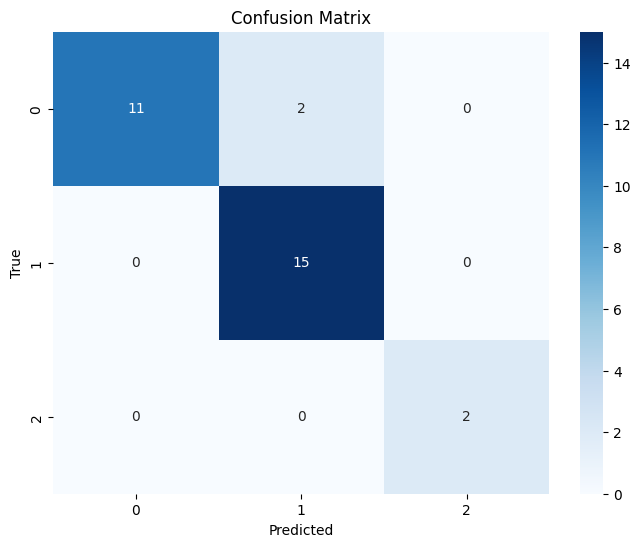

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the true labels tensor to a numpy array
true_labels_np = true_labels.numpy()

# Create the confusion matrix
cm = confusion_matrix(true_labels_np, predicted_labels)

# Define the action classes
action_classes = sorted(np.unique(true_labels_np))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=action_classes, yticklabels=action_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()